# Lab Two: Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our data set consists of over 5 million rows of flight information in the domestic United States for the year of 2015. In order to optimize our modeling time, we have narrowed the scope of our classification tasks to the Dallas area only (Dallas Love Field and DFW airports). 

The goal for this project is to build two classification models to predict the following for the DFW area:
1. Whether or not the flight was cancelled (our binary classification model)
2. For delayed flights, how long was the delay (in terms of groups - our multi-class classification model).

Because the scope of our two classification models is different, we will create two data sets for each modelling task.

## 1. Data Preparation

- **[10 points]** Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [6]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from datetime import datetime
import altair as alt
import datetime

#machine learning
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Import data

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
# Read in the data using Pandas
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

C:\Users\megan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

In [4]:
# check variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 32 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE_CODE           object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    object
DEPARTURE_TIME         object
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             object
SCHEDULED_TIME         object
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              object
TAXI_IN                float64
SCHEDULED_ARRIVAL      object
ARRIVAL_TIME           object
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DE

### 1.1 Subset to DFW area

This step will reduce our data down to flights departing from Dallas area airports only.

In [5]:
df = df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL')]

In [6]:
df.shape

(299250, 32)

In [7]:
#check airline counts
df['AIRLINE'].value_counts()

American Airlines Inc.          134270
American Eagle Airlines Inc.     53603
Southwest Airlines Co.           52670
Atlantic Southeast Airlines      24649
Spirit Air Lines                  8519
Delta Air Lines Inc.              6532
Virgin America                    5050
Skywest Airlines Inc.             4136
United Air Lines Inc.             3505
US Airways Inc.                   3082
Alaska Airlines Inc.              1348
Frontier Airlines Inc.            1288
JetBlue Airways                    598
Name: AIRLINE, dtype: int64

American Airlines is the max class (as expected), but we do still have a decent sample size for some of the smaller airlines. We have reduced the data down from 5 million+ rows to 598,535 rows which is a much more manageable size (although still a lot of data!).

In [8]:
#check cancellations
df['CANCELLED'].value_counts()

0    292146
1      7104
Name: CANCELLED, dtype: int64

This is an unbalanced data set for one of our desired classification items, which is whether or not the flight is cancelled. When we are doing our test and training splits, we can either under or oversample our data, or choose a different cut-off value to optimize sensitivity and specificity in this binary classification.

### 1.2 Create New Variables

First we create a date column for joining up to Dallas weather information.

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we created buckets to analyze similar attributes together.

We first convert SCHEDULED_DEPARTURE, DEPARTURE_TIME, ARRIVAL_TIME, and SCHEDULED_ARRIVAL into buckets based on their timestamp.

    Overnight: 12:00am - 5:59am
    Morning: 6:00am - 11:59am
    Afternoon: 12:00pm - 5:59pm
    Evening: 6:00pm - 11:59pm

[Flight] DISTANCE is also divided into buckets.

    Short: 1-99 miles
    Medium: 100-999 miles
    Long: 1,000+ miles



In [9]:
#Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 600, 1200, 1800, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'].astype(float), 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'].astype(float), 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,0515,0703,108.0,15.0,0718,161,155.0,133.0,1121,1031,7.0,0856,1038,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long
124,2015,1,1,4,DL,1890,N377DA,DFW,ATL,0545,0603,18.0,13.0,0616,124,104.0,86.0,731,0842,5.0,0849,0847,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium
203,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,0600,0606,6.0,18.0,0624,145,142.0,120.0,985,0924,4.0,0925,0928,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,morning,morning,morning,Medium
209,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,0600,0554,-6.0,33.0,0627,190,191.0,154.0,1389,1001,4.0,1010,1005,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning,Long
310,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,0600,NaN,NaN,NaN,NaN,78,NaN,NaN,383,NaN,NaN,0718,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Eagle Airlines Inc.,overnight,NaN,morning,NaN,Medium


In [10]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
actual_arrival = df['ACTUAL_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', actual_arrival, '\n\n', dist_bucket)

afternoon    111632
morning      106543
evening       76617
overnight      4458
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 afternoon    109057
morning      100388
evening       78415
overnight      4660
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 afternoon    113185
evening      108932
morning       73270
overnight      3863
Name: SCHED_ARRIVAL_TIME, dtype: int64 

 afternoon    108247
evening      105503
morning       70146
overnight      7886
Name: ACTUAL_ARRIVAL_TIME, dtype: int64 

 Medium    210290
Long       87349
Short       1611
Name: DISTANCE_BUCKET, dtype: int64


In [11]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,0515,0703,108.0,15.0,0718,161,155.0,133.0,1121,1031,7.0,0856,1038,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1
124,2015,1,1,4,DL,1890,N377DA,DFW,ATL,0545,0603,18.0,13.0,0616,124,104.0,86.0,731,0842,5.0,0849,0847,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0
203,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,0600,0606,6.0,18.0,0624,145,142.0,120.0,985,0924,4.0,0925,0928,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,morning,morning,morning,Medium,1
209,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,0600,0554,-6.0,33.0,0627,190,191.0,154.0,1389,1001,4.0,1010,1005,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning,Long,0
310,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,0600,NaN,NaN,NaN,NaN,78,NaN,NaN,383,NaN,NaN,0718,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Eagle Airlines Inc.,overnight,NaN,morning,NaN,Medium,1


### 1.3 Process Dates & Times

In [12]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

Next we'll write a function to convert the numeric time strings into datetime format.

In [13]:
# Creating a function to change the way of representation of time in the column
def fun_format_time(hours):
        if hours == 2400:
            hours = 0
        else:
            hours = "{0:04d}".format(int(hours))
            Hourmin = datetime.time(int(hours[0:2]), int(hours[2:4]))
            return Hourmin

In [14]:
# Define the time columns
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        #"SCHEDULED_TIME",
        "ARRIVAL_TIME",
        "WHEELS_ON",
        "WHEELS_OFF"]

In [15]:
# Look at the data prior to conversion
df[cols].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,WHEELS_ON,WHEELS_OFF
70,0515,0703,0856,1038,1031,0718
124,0545,0603,0849,0847,0842,0616
203,0600,0606,0925,0928,0924,0624
209,0600,0554,1010,1005,1001,0627
310,0600,NaN,0718,NaN,NaN,NaN


We noticed that record 42 has NaN where times should be. This is an example of a cancelled flight. We'll need to have our function exclude those when it processes the columns. 

In [16]:
# Convert times to float in order to correctly process them through the function
df[cols] = df[cols].astype(float)

In [17]:
# Run times through the new function
# Code adapted from: https://stackoverflow.com/questions/35232705/how-to-test-for-nans-in-an-apply-function-in-pandas
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['DEPARTURE_TIME']      = df['DEPARTURE_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['SCHEDULED_ARRIVAL']   = df['SCHEDULED_ARRIVAL'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['ARRIVAL_TIME']        = df['ARRIVAL_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
# df['SCHEDULED_TIME']      = df['SCHEDULED_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_ON']           = df['WHEELS_ON'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_OFF']          = df['WHEELS_OFF'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)

In [18]:
df[cols].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,WHEELS_ON,WHEELS_OFF
70,05:15:00,07:03:00,08:56:00,10:38:00,10:31:00,07:18:00
124,05:45:00,06:03:00,08:49:00,08:47:00,08:42:00,06:16:00
203,06:00:00,06:06:00,09:25:00,09:28:00,09:24:00,06:24:00
209,06:00:00,05:54:00,10:10:00,10:05:00,10:01:00,06:27:00
310,06:00:00,NaN,07:18:00,NaN,NaN,NaN


Now that we have the times correctly formatted, let's combine the `FLIGHT_DATE` feature with `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL` to create a complete datetime feature for each.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299250 entries, 70 to 5819003
Data columns (total 39 columns):
YEAR                     299250 non-null int64
MONTH                    299250 non-null int64
DAY                      299250 non-null int64
DAY_OF_WEEK              299250 non-null int64
AIRLINE_CODE             299250 non-null object
FLIGHT_NUMBER            299250 non-null int64
TAIL_NUMBER              298690 non-null object
ORIGIN_AIRPORT           299250 non-null object
DESTINATION_AIRPORT      299250 non-null object
SCHEDULED_DEPARTURE      299250 non-null object
DEPARTURE_TIME           292520 non-null object
DEPARTURE_DELAY          292533 non-null float64
TAXI_OUT                 292244 non-null float64
WHEELS_OFF               292215 non-null object
SCHEDULED_TIME           299250 non-null object
ELAPSED_TIME             291319 non-null float64
AIR_TIME                 291319 non-null float64
DISTANCE                 299250 non-null int64
WHEELS_ON                

In [20]:
# Source: https://stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-python-pandas

# Combine date & time for departure and arrival
df['SCHEDULED_DEPARTURE_DT'] = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_DEPARTURE'].astype(str))
df['SCHEDULED_ARRIVAL_DT']   = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_ARRIVAL'].astype(str))

In [21]:
# Look at the columns to make sure everything looks correct
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,FLIGHT_DATE,SCHEDULED_DEPARTURE_DT,SCHEDULED_ARRIVAL_DT
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,05:15:00,07:03:00,108.0,15.0,07:18:00,161,155.0,133.0,1121,10:31:00,7.0,08:56:00,10:38:00,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1,2015-01-01,2015-01-01 05:15:00,2015-01-01 08:56:00
124,2015,1,1,4,DL,1890,N377DA,DFW,ATL,05:45:00,06:03:00,18.0,13.0,06:16:00,124,104.0,86.0,731,08:42:00,5.0,08:49:00,08:47:00,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0,2015-01-01,2015-01-01 05:45:00,2015-01-01 08:49:00
203,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,06:00:00,06:06:00,6.0,18.0,06:24:00,145,142.0,120.0,985,09:24:00,4.0,09:25:00,09:28:00,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,morning,morning,morning,Medium,1,2015-01-01,2015-01-01 06:00:00,2015-01-01 09:25:00
209,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,06:00:00,05:54:00,-6.0,33.0,06:27:00,190,191.0,154.0,1389,10:01:00,4.0,10:10:00,10:05:00,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning,Long,0,2015-01-01,2015-01-01 06:00:00,2015-01-01 10:10:00
310,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,06:00:00,NaN,NaN,NaN,NaN,78,NaN,NaN,383,NaN,NaN,07:18:00,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Eagle Airlines Inc.,overnight,NaN,morning,NaN,Medium,1,2015-01-01,2015-01-01 06:00:00,2015-01-01 07:18:00


### 1.4 Append Dallas-Area Weather

We download historical weather data for the DFW area from [Open Weather](https://openweathermap.org) and will append it to our data set in order to use it with our models.

In [22]:
# Read in the data
import datetime
weather = pd.read_csv('../Data/dfw_weather.csv')
weather['dt_iso'] = weather['dt_iso'].astype(str)

In [23]:
# Remove "+0000 UTC"
weather['dt_iso_update'] = weather['dt_iso'].str.split('+').str[0]

In [24]:
# Look at the data
weather.info()
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68238 entries, 0 to 68237
Data columns (total 26 columns):
dt                     68238 non-null int64
dt_iso                 68238 non-null object
timezone               68238 non-null int64
city_name              68238 non-null object
lat                    68238 non-null float64
lon                    68238 non-null float64
temp                   68238 non-null float64
feels_like             68238 non-null float64
temp_min               68238 non-null float64
temp_max               68238 non-null float64
pressure               68238 non-null int64
sea_level              0 non-null float64
grnd_level             0 non-null float64
humidity               68238 non-null int64
wind_speed             68238 non-null float64
wind_deg               68238 non-null int64
rain_1h                7593 non-null float64
rain_3h                1261 non-null float64
snow_1h                247 non-null float64
snow_3h                43 non-null float6

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,dt_iso_update
0,1388534400,2014-01-01 00:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,46.98,35.71,42.80,50.00,1025,NaN,NaN,37,11.50,160,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n,2014-01-01 00:00:00
1,1388538000,2014-01-01 01:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,44.51,32.25,40.64,48.20,1024,NaN,NaN,46,13.80,140,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 01:00:00
2,1388541600,2014-01-01 02:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,42.76,32.70,39.00,46.40,1024,NaN,NaN,42,9.22,160,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 02:00:00
3,1388545200,2014-01-01 03:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,42.58,31.23,37.40,46.94,1024,NaN,NaN,42,11.50,170,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 03:00:00
4,1388548800,2014-01-01 04:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,41.85,29.91,37.04,44.96,1023,NaN,NaN,45,12.66,160,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 04:00:00


In [25]:
# Convert new column to a datetime type
weather['date_time'] =  pd.to_datetime(weather['dt_iso_update'], format='%Y-%m-%d %H:%M')

In [26]:
weather['date_time'] = weather['date_time'].dt.round('30min')  
df['SCHEDULED_DEPARTURE_DT'] = df['SCHEDULED_DEPARTURE_DT'].dt.round('30min')

In [27]:
df = pd.merge(df, weather, left_on='SCHEDULED_DEPARTURE_DT', right_on='date_time')
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,FLIGHT_DATE,SCHEDULED_DEPARTURE_DT,SCHEDULED_ARRIVAL_DT,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,dt_iso_update,date_time
0,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,05:15:00,07:03:00,108.0,15.0,07:18:00,161,155.0,133.0,1121,10:31:00,7.0,08:56:00,10:38:00,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1,2015-01-01,2015-01-01 05:00:00,2015-01-01 08:56:00,1420088400,2015-01-01 05:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,35.11,27.99,33.98,37.04,1031,NaN,NaN,66,4.7,20,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n,2015-01-01 05:00:00,2015-01-01 05:00:00
1,2015,1,1,4,DL,1890,N377DA,DFW,ATL,05:45:00,06:03:00,18.0,13.0,06:16:00,124,104.0,86.0,731,08:42:00,5.0,08:49:00,08:47:00,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0,2015-01-01,2015-01-01 06:00:00,2015-01-01 08:49:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00
2,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,06:00:00,06:06:00,6.0,18.0,06:24:00,145,142.0,120.0,985,09:24:00,4.0,09:25:00,09:28:00,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,morning,morning,morning,Medium,1,2015-01-01,2015-01-01 06:00:00,2015-01-01 09:25:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00
3,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,06:00:00,05:54:00,-6.0,33.0,06:27:00,190,191.0,154.0,1389,10:01:00,4.0,10:10:00,10:05:00,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning,Long,0,2015-01-01,2015-01-01 06:00:00,2015-01-01 10:10:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00
4,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,06:00:00,NaN,NaN,NaN,NaN,78,NaN,NaN,383,NaN,NaN,07:18:00,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Eagle Airlines Inc.,overnight,NaN,morning,NaN,Medium,1,2015-01-01,2015-01-01 06:00:00,2015-01-01 07:18:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00


In [28]:
df['CANCELLED'].value_counts()

0    198038
1      6189
Name: CANCELLED, dtype: int64

In [29]:
#remove unnecessary columns from weather data
col_to_drop = ['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'feels_like', 'temp_min', 'temp_max',
              'sea_level', 'grnd_level', 'dt_iso_update', 'weather_icon', 'weather_description', 'date_time']
df = df.drop(columns = col_to_drop)

### 1.5 Missing Values

In [30]:
#check missing values
df.isnull().sum()

YEAR                           0
MONTH                          0
DAY                            0
DAY_OF_WEEK                    0
AIRLINE_CODE                   0
FLIGHT_NUMBER                  0
TAIL_NUMBER                  485
ORIGIN_AIRPORT                 0
DESTINATION_AIRPORT            0
SCHEDULED_DEPARTURE            0
DEPARTURE_TIME              5920
DEPARTURE_DELAY             5908
TAXI_OUT                    6109
WHEELS_OFF                  6129
SCHEDULED_TIME                 0
ELAPSED_TIME                6769
AIR_TIME                    6769
DISTANCE                       0
WHEELS_ON                   6425
TAXI_IN                     6320
SCHEDULED_ARRIVAL              0
ARRIVAL_TIME                6447
ARRIVAL_DELAY               6769
DIVERTED                       0
CANCELLED                      0
CANCELLATION_REASON       198038
AIR_SYSTEM_DELAY          159629
SECURITY_DELAY            159629
AIRLINE_DELAY             159629
LATE_AIRCRAFT_DELAY       159629
WEATHER_DE

In [31]:
#check cancellations
df['CANCELLED'].value_counts()

0    198038
1      6189
Name: CANCELLED, dtype: int64

In [32]:
#remove non-critical columns WHEELS_ON and WHEELS_OFF
df = df.drop(['WHEELS_ON','WHEELS_OFF'], axis=1)

In [33]:
#add category
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].cat.add_categories(['N'])
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].cat.add_categories(['N'])

#fill missing values with 'N' for 'N/A'
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].fillna('N')
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].fillna('N')

In [34]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

In [35]:
#check missing values left
df.isnull().sum()

YEAR                        0
MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE_CODE                0
FLIGHT_NUMBER               0
TAIL_NUMBER               485
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTED                    0
DEPARTURE_DELAY             0
TAXI_OUT                    0
SCHEDULED_TIME              0
ELAPSED_TIME              580
AIR_TIME                  580
DISTANCE                    0
TAXI_IN                   131
SCHEDULED_ARRIVAL           0
ARRIVED                     0
ARRIVAL_DELAY             580
DIVERTED                    0
CANCELLED                   0
CANCELLATION_REASON         0
AIR_SYSTEM_DELAY            0
SECURITY_DELAY              0
AIRLINE_DELAY               0
LATE_AIRCRAFT_DELAY         0
WEATHER_DELAY               0
AIRLINE                     0
SCHED_DEPARTURE_TIME        0
ACTUAL_DEPARTURE_TIME       0
SCHED_ARRIVAL_TIME          0
ACTUAL_ARR

In [36]:
#drop remaining missing values and check total cancels left
df = df.dropna()
df['CANCELLED'].value_counts()

0    197458
1      5704
Name: CANCELLED, dtype: int64

In [37]:
#make sure to delete date columns
df = df.drop(columns = ['FLIGHT_DATE', 'SCHEDULED_DEPARTURE_DT', 'SCHEDULED_ARRIVAL_DT'])

In [38]:
#convert back to string
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(str)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(str)

#remove colons
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.str.replace(r'\D+', '')
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.str.replace(r'\D+', '')

#convert to float
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(int)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(int)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203162 entries, 0 to 204226
Data columns (total 48 columns):
YEAR                     203162 non-null int64
MONTH                    203162 non-null int64
DAY                      203162 non-null int64
DAY_OF_WEEK              203162 non-null int64
AIRLINE_CODE             203162 non-null object
FLIGHT_NUMBER            203162 non-null int64
TAIL_NUMBER              203162 non-null object
ORIGIN_AIRPORT           203162 non-null object
DESTINATION_AIRPORT      203162 non-null object
SCHEDULED_DEPARTURE      203162 non-null int32
DEPARTED                 203162 non-null int64
DEPARTURE_DELAY          203162 non-null float64
TAXI_OUT                 203162 non-null float64
SCHEDULED_TIME           203162 non-null object
ELAPSED_TIME             203162 non-null float64
AIR_TIME                 203162 non-null float64
DISTANCE                 203162 non-null int64
TAXI_IN                  203162 non-null float64
SCHEDULED_ARRIVAL        203

In [40]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main
0,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,51500,1,108.0,15.0,161,155.0,133.0,1121,7.0,85600,1,102.0,0,0,N,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1,35.11,1031,66,4.7,20,0.0,0.0,0.0,0.0,90,804,Clouds
1,2015,1,1,4,DL,1890,N377DA,DFW,ATL,54500,1,18.0,13.0,124,104.0,86.0,731,5.0,84900,1,-2.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain
2,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,60000,1,6.0,18.0,145,142.0,120.0,985,4.0,92500,1,3.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,morning,morning,morning,Medium,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain
3,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,60000,1,-6.0,33.0,190,191.0,154.0,1389,4.0,101000,1,-5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain
4,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,60000,1,0.0,0.0,78,0.0,0.0,383,0.0,71800,1,0.0,0,1,B,0.0,0.0,0.0,0.0,0.0,American Eagle Airlines Inc.,overnight,N,morning,N,Medium,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain


### 1.6 Log Transformations

As we discovered during Lab 1, the DEPARTURE_DELAY, ARRIVAL_DELAY, DISTANCE, TAXI_IN, ELAPSED_TIME, and AIR_TIME variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [41]:
min(df["DEPARTURE_DELAY"])

-24.0

In [42]:
min(df["ARRIVAL_DELAY"])

-56.0

In [43]:
min(df["DISTANCE"])

89

In [44]:
min(df["TAXI_IN"])

0.0

In [45]:
min(df["ELAPSED_TIME"])

0.0

In [46]:
min(df["AIR_TIME"])

0.0

In [47]:
# Log transformation keeping the 0 in the data sets. Because we have negative values, need to offset to make minimum
# equal to zero and not a negative number. For the other vars, no need to run lambda function as min > 0 which improves
# run time
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log(i + 24) if i != -24 else 0) 
df["ARRIVAL_DELAY_log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log(i + 56) if i != -56 else 0)
df["DISTANCE_log"]        = np.log(df["DISTANCE"])
df["TAXI_IN_log"]         = np.log1p(df["TAXI_IN"])
df["ELAPSED_TIME_log"]    = np.log1p(df["ELAPSED_TIME"])
df["AIR_TIME_log"]        = np.log1p(df["AIR_TIME"])

In [48]:
#check calculations
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,51500,1,108.0,15.0,161,155.0,133.0,1121,7.0,85600,1,102.0,0,0,N,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1,35.11,1031,66,4.7,20,0.0,0.0,0.0,0.0,90,804,Clouds,4.882802,5.062595,7.021976,2.079442,5.049856,4.897840
1,2015,1,1,4,DL,1890,N377DA,DFW,ATL,54500,1,18.0,13.0,124,104.0,86.0,731,5.0,84900,1,-2.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,3.737670,3.988984,6.594413,1.791759,4.653960,4.465908
2,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,60000,1,6.0,18.0,145,142.0,120.0,985,4.0,92500,1,3.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,morning,morning,morning,Medium,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,3.401197,4.077537,6.892642,1.609438,4.962845,4.795791
3,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,60000,1,-6.0,33.0,190,191.0,154.0,1389,4.0,101000,1,-5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,morning,Long,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,2.890372,3.931826,7.236339,1.609438,5.257495,5.043425
4,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,60000,1,0.0,0.0,78,0.0,0.0,383,0.0,71800,1,0.0,0,1,B,0.0,0.0,0.0,0.0,0.0,American Eagle Airlines Inc.,overnight,N,morning,N,Medium,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,3.178054,4.025352,5.948035,0.000000,0.000000,0.000000


### 1.7 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:

- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have AIRLINE_CODE which is the same information

In [49]:
col_to_drop1 = ['YEAR','AIRLINE']
df = df.drop(columns = col_to_drop1)

In [50]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log
0,1,1,4,AA,1057,N3ASAA,DFW,MIA,51500,1,108.0,15.0,161,155.0,133.0,1121,7.0,85600,1,102.0,0,0,N,0.0,0.0,0.0,0.0,102.0,overnight,morning,morning,morning,Long,1,35.11,1031,66,4.7,20,0.0,0.0,0.0,0.0,90,804,Clouds,4.882802,5.062595,7.021976,2.079442,5.049856,4.897840
1,1,1,4,DL,1890,N377DA,DFW,ATL,54500,1,18.0,13.0,124,104.0,86.0,731,5.0,84900,1,-2.0,0,0,N,0.0,0.0,0.0,0.0,0.0,overnight,morning,morning,morning,Medium,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,3.737670,3.988984,6.594413,1.791759,4.653960,4.465908
2,1,1,4,AA,72,N5EKAA,DFW,MCO,60000,1,6.0,18.0,145,142.0,120.0,985,4.0,92500,1,3.0,0,0,N,0.0,0.0,0.0,0.0,0.0,overnight,morning,morning,morning,Medium,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,3.401197,4.077537,6.892642,1.609438,4.962845,4.795791
3,1,1,4,AA,1100,N3GWAA,DFW,LGA,60000,1,-6.0,33.0,190,191.0,154.0,1389,4.0,101000,1,-5.0,0,0,N,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,morning,Long,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,2.890372,3.931826,7.236339,1.609438,5.257495,5.043425
4,1,1,4,MQ,3015,N825MQ,DFW,BTR,60000,1,0.0,0.0,78,0.0,0.0,383,0.0,71800,1,0.0,0,1,B,0.0,0.0,0.0,0.0,0.0,overnight,N,morning,N,Medium,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,Rain,3.178054,4.025352,5.948035,0.000000,0.000000,0.000000


### 1.8 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [51]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N906EV    786
N902EV    772
N905EV    769
N904EV    757
N901EV    752
N903EV    752
N880AS    720
N876AS    689
N879AS    682
N877AS    681
N907EV    676
N909EV    657
N908EV    617
N685AE    592
N687JS    586
N673AE    558
N680AE    553
N671AE    548
N667GB    541
N523SW    529
N520SW    529
N528SW    524
N677AE    511
N522SW    499
N675AE    469
N684JW    467
N526SW    465
N676AE    462
N515SW    450
N678AE    449
         ... 
N519JB      1
N740EV      1
N69819      1
N383DN      1
N14214      1
N586JB      1
N827JB      1
N37462      1
N653AW      1
N554JB      1
N78438      1
N835DN      1
N577AS      1
N648JB      1
N26141      1
N614AS      1
N640JB      1
N748UW      1
N24103      1
N37255      1
N517JB      1
N68805      1
N3767       1
N674DL      1
N763JB      1
N61887      1
N468UA      1
N13988      1
N3768       1
N3735D      1
Name: TAIL_NUMBER, Length: 3542, dtype: int64
DFW    163200
DAL     39962
Name: ORIGIN_AIRPORT, dtype: int64
ATL    7044
AUS    6407
LAX    5928
H

We have 3,542 different airplanes (`TAIL_NUMBER`) and 148 different destination airpots. If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers so that we have a greater likelihood of including it within either the train or test set. The minimum group size of the origin and destination airports is sufficiently large to avoid this problem.

In [52]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
print(df['TAIL_NUMBER'].value_counts())

N906EV    786
N902EV    772
N905EV    769
N904EV    757
N903EV    752
N901EV    752
N880AS    720
N876AS    689
N879AS    682
N877AS    681
N907EV    676
N909EV    657
N908EV    617
N685AE    592
N687JS    586
N673AE    558
N680AE    553
N671AE    548
N667GB    541
N520SW    529
N523SW    529
N528SW    524
N677AE    511
N522SW    499
N675AE    469
N684JW    467
N526SW    465
N676AE    462
N515SW    450
N678AE    449
         ... 
N338NW      5
N7AFAA      5
N3NCAA      5
N14231      5
N407UA      5
N566AS      5
N702UW      5
N608AT      5
N5FAAA      5
N594AS      5
N549CA      5
N493UA      5
N206FR      5
N608SK      5
N338NB      5
N942AT      5
N332NB      5
N710UW      5
N570AS      5
N12924      5
N7ASAA      5
N16713      5
N975UY      5
N760US      5
N284JB      5
N220FR      5
N331NW      5
N346AA      5
N606SK      5
N12996      5
Name: TAIL_NUMBER, Length: 2660, dtype: int64


This now reduces to 2,660 unique tail numbers. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns without moving to a cloud-based solution.

In [53]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['DESTINATION_AIRPORT_encode'] = labelencoder.fit_transform(df['DESTINATION_AIRPORT'])
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

Wall time: 1.04 s


In [54]:
# Drop original columns
col_to_drop2 = ['TAIL_NUMBER','DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop2)

For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 52 columns):
MONTH                         201236 non-null int64
DAY                           201236 non-null int64
DAY_OF_WEEK                   201236 non-null int64
AIRLINE_CODE                  201236 non-null object
FLIGHT_NUMBER                 201236 non-null int64
ORIGIN_AIRPORT                201236 non-null object
SCHEDULED_DEPARTURE           201236 non-null int32
DEPARTED                      201236 non-null int64
DEPARTURE_DELAY               201236 non-null float64
TAXI_OUT                      201236 non-null float64
SCHEDULED_TIME                201236 non-null object
ELAPSED_TIME                  201236 non-null float64
AIR_TIME                      201236 non-null float64
DISTANCE                      201236 non-null int64
TAXI_IN                       201236 non-null float64
SCHEDULED_ARRIVAL             201236 non-null int32
ARRIVED                       201236 non-nul

In [56]:
#total cancel check
df['CANCELLED'].value_counts()

0    195553
1      5683
Name: CANCELLED, dtype: int64

In [57]:
%%time

categorical_columns = ['AIRLINE_CODE', 'CANCELLATION_REASON', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME',
                       'DISTANCE_BUCKET', 'weather_main', 'ORIGIN_AIRPORT']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns, drop_first = True)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

Wall time: 5.56 s


,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTED,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVED,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,DEPARTURE_DELAY_log,ARRIVAL_DELAY_log,DISTANCE_log,TAXI_IN_log,ELAPSED_TIME_log,AIR_TIME_log,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_N,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_N,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,ACTUAL_ARRIVAL_TIME_morning,ACTUAL_ARRIVAL_TIME_afternoon,ACTUAL_ARRIVAL_TIME_evening,ACTUAL_ARRIVAL_TIME_N,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,weather_main_Clouds,weather_main_Drizzle,weather_main_Dust,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Snow,weather_main_Thunderstorm,ORIGIN_AIRPORT_DFW
0,1,1,4,1057,51500,1,108.0,15.0,161,155.0,133.0,1121,7.0,85600,1,102.0,0,0,0.0,0.0,0.0,0.0,102.0,1,35.11,1031,66,4.7,20,0.0,0.0,0.0,0.0,90,804,4.882802,5.062595,7.021976,2.079442,5.049856,4.897840,90,581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
2,1,1,4,72,60000,1,6.0,18.0,145,142.0,120.0,985,4.0,92500,1,3.0,0,0,0.0,0.0,0.0,0.0,0.0,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,3.401197,4.077537,6.892642,1.609438,4.962845,4.795791,83,1392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
3,1,1,4,1100,60000,1,-6.0,33.0,190,191.0,154.0,1389,4.0,101000,1,-5.0,0,0,0.0,0.0,0.0,0.0,0.0,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,2.890372,3.931826,7.236339,1.609438,5.257495,5.043425,78,716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
4,1,1,4,3015,60000,1,0.0,0.0,78,0.0,0.0,383,0.0,71800,1,0.0,0,1,0.0,0.0,0.0,0.0,0.0,1,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,3.178054,4.025352,5.948035,0.000000,0.000000,0.000000,16,2075,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1
5,1,1,4,925,60000,1,0.0,13.0,238,209.0,188.0,1457,8.0,75800,1,-29.0,0,0,0.0,0.0,0.0,0.0,0.0,0,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,3.178054,3.295837,7.284135,2.197225,5.347108,5.241747,100,1554,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [58]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 84 columns):
MONTH                              201236 non-null int64
DAY                                201236 non-null int64
DAY_OF_WEEK                        201236 non-null int64
FLIGHT_NUMBER                      201236 non-null int64
SCHEDULED_DEPARTURE                201236 non-null int32
DEPARTED                           201236 non-null int64
DEPARTURE_DELAY                    201236 non-null float64
TAXI_OUT                           201236 non-null float64
SCHEDULED_TIME                     201236 non-null object
ELAPSED_TIME                       201236 non-null float64
AIR_TIME                           201236 non-null float64
DISTANCE                           201236 non-null int64
TAXI_IN                            201236 non-null float64
SCHEDULED_ARRIVAL                  201236 non-null int32
ARRIVED                            201236 non-null int64
ARRIVAL_DELAY          

In [59]:
#scheduled time needs to be int
df_OHE['SCHEDULED_TIME'] = df_OHE['SCHEDULED_TIME'].astype(int)

In [60]:
#add response variable bucket for delay time for departure
#0 is Early (negative time)
#1 is On_Time or between 0 and 10 minutes late
#2 is Late (between 11 and 30 min late)
#3 is very late (between 31 and 60 min late)
#4 is extremely late (over 61 min late)

delay_labels = ['0', '1', '2', '3', '4']
delay_bins   = [-np.inf, 0, 10, 30, 60, np.inf]
df_OHE['DELAY_BUCKET'] = pd.cut(df_OHE['DEPARTURE_DELAY'],
                               bins=delay_bins,
                               labels=delay_labels)

#check counts by bucket
df_OHE['DELAY_BUCKET'].value_counts()

0    116022
1     33546
2     24784
3     13854
4     13030
Name: DELAY_BUCKET, dtype: int64

In [61]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 85 columns):
MONTH                              201236 non-null int64
DAY                                201236 non-null int64
DAY_OF_WEEK                        201236 non-null int64
FLIGHT_NUMBER                      201236 non-null int64
SCHEDULED_DEPARTURE                201236 non-null int32
DEPARTED                           201236 non-null int64
DEPARTURE_DELAY                    201236 non-null float64
TAXI_OUT                           201236 non-null float64
SCHEDULED_TIME                     201236 non-null int32
ELAPSED_TIME                       201236 non-null float64
AIR_TIME                           201236 non-null float64
DISTANCE                           201236 non-null int64
TAXI_IN                            201236 non-null float64
SCHEDULED_ARRIVAL                  201236 non-null int32
ARRIVED                            201236 non-null int64
ARRIVAL_DELAY           

In [62]:
#convert from category to int
df_OHE['DELAY_BUCKET'] = df_OHE['DELAY_BUCKET'].astype(int)

### 1.7 Make New Data Sets

Here, we will start to remove variables based on our desired response variable and then check correlations for further removals. We will drop the non-transformed versions of the below groups since it is duplicated and will naturally be correlated to the log version.

In [63]:
col_to_drop3 = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']
df_OHE = df_OHE.drop(columns = col_to_drop3)

In [64]:
#make a copy of our data for each new set
df_cancel = df_OHE
df_delay = df_OHE

#drop delay bucket from cancellation set
df_cancel = df_cancel.drop(columns = 'DELAY_BUCKET')

#### 1.7.1 Delay Data Set

We can remove several variables for our delay bucket group. We will filter out any cancelled flights, as these are not delayed. Then we can also remove `CANCELLED` and our `CANCELLATION_REASON` encoded columns. Because we don't know whether or not the flight will be delayed prior to the analysis, we will also remove `ACTUAL_ARRIVAL_TIME` and `ACTUAL_DEPARTURE_TIME` and all of of our other delay time related columns.

In [65]:
#filter out cancelled flights
df_delay = df_delay[df_delay.CANCELLED == 0]

col_to_drop4 = ['CANCELLED', 'CANCELLATION_REASON_B', 'CANCELLATION_REASON_C', 'CANCELLATION_REASON_N', 
               'ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening',
               'ACTUAL_DEPARTURE_TIME_N', 'ACTUAL_ARRIVAL_TIME_morning', 'ACTUAL_ARRIVAL_TIME_afternoon', 
                'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                'ACTUAL_ARRIVAL_TIME_evening','ACTUAL_ARRIVAL_TIME_N','AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAYED', 
                'DEPARTURE_DELAY_log','ARRIVAL_DELAY_log', 'ELAPSED_TIME_log', 'DEPARTED', 'ARRIVED',
               'TAXI_IN_log', 'AIR_TIME_log']

df_delay = df_delay.drop(columns = col_to_drop4)

In [66]:
df_delay.shape

(195553, 52)

In [67]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195553 entries, 0 to 204226
Data columns (total 52 columns):
MONTH                             195553 non-null int64
DAY                               195553 non-null int64
DAY_OF_WEEK                       195553 non-null int64
FLIGHT_NUMBER                     195553 non-null int64
TAXI_OUT                          195553 non-null float64
SCHEDULED_TIME                    195553 non-null int32
DIVERTED                          195553 non-null int64
temp                              195553 non-null float64
pressure                          195553 non-null int64
humidity                          195553 non-null int64
wind_speed                        195553 non-null float64
wind_deg                          195553 non-null int64
rain_1h                           195553 non-null float64
rain_3h                           195553 non-null float64
snow_1h                           195553 non-null float64
snow_3h                           195

#### 1.7.2 Cancelled data set

In [68]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 78 columns):
MONTH                              201236 non-null int64
DAY                                201236 non-null int64
DAY_OF_WEEK                        201236 non-null int64
FLIGHT_NUMBER                      201236 non-null int64
SCHEDULED_DEPARTURE                201236 non-null int32
DEPARTED                           201236 non-null int64
TAXI_OUT                           201236 non-null float64
SCHEDULED_TIME                     201236 non-null int32
SCHEDULED_ARRIVAL                  201236 non-null int32
ARRIVED                            201236 non-null int64
DIVERTED                           201236 non-null int64
CANCELLED                          201236 non-null int64
AIR_SYSTEM_DELAY                   201236 non-null float64
SECURITY_DELAY                     201236 non-null float64
AIRLINE_DELAY                      201236 non-null float64
LATE_AIRCRAFT_DELAY       

If the flight was cancelled, we know that we no longer need the `DEPARTED`, `ARRIVED`, `DIVERTED`, and `DELAYED` columns so we will drop these. Additionally, we will not have any actual departure or arrival times.

In [69]:
col_to_drop6 = ['DEPARTED', 'DIVERTED', 'ARRIVED', 'DIVERTED',
               'ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening',
               'ACTUAL_DEPARTURE_TIME_N', 'ACTUAL_ARRIVAL_TIME_morning', 'ACTUAL_ARRIVAL_TIME_afternoon',
               'ACTUAL_ARRIVAL_TIME_evening', 'ACTUAL_ARRIVAL_TIME_N']

df_cancel = df_cancel.drop(columns = col_to_drop6)

In [70]:
#total cancel check
df_cancel['CANCELLED'].value_counts()

0    195553
1      5683
Name: CANCELLED, dtype: int64

### 1.8 Check Correlations

#### 1.8.1 Delay Data Set

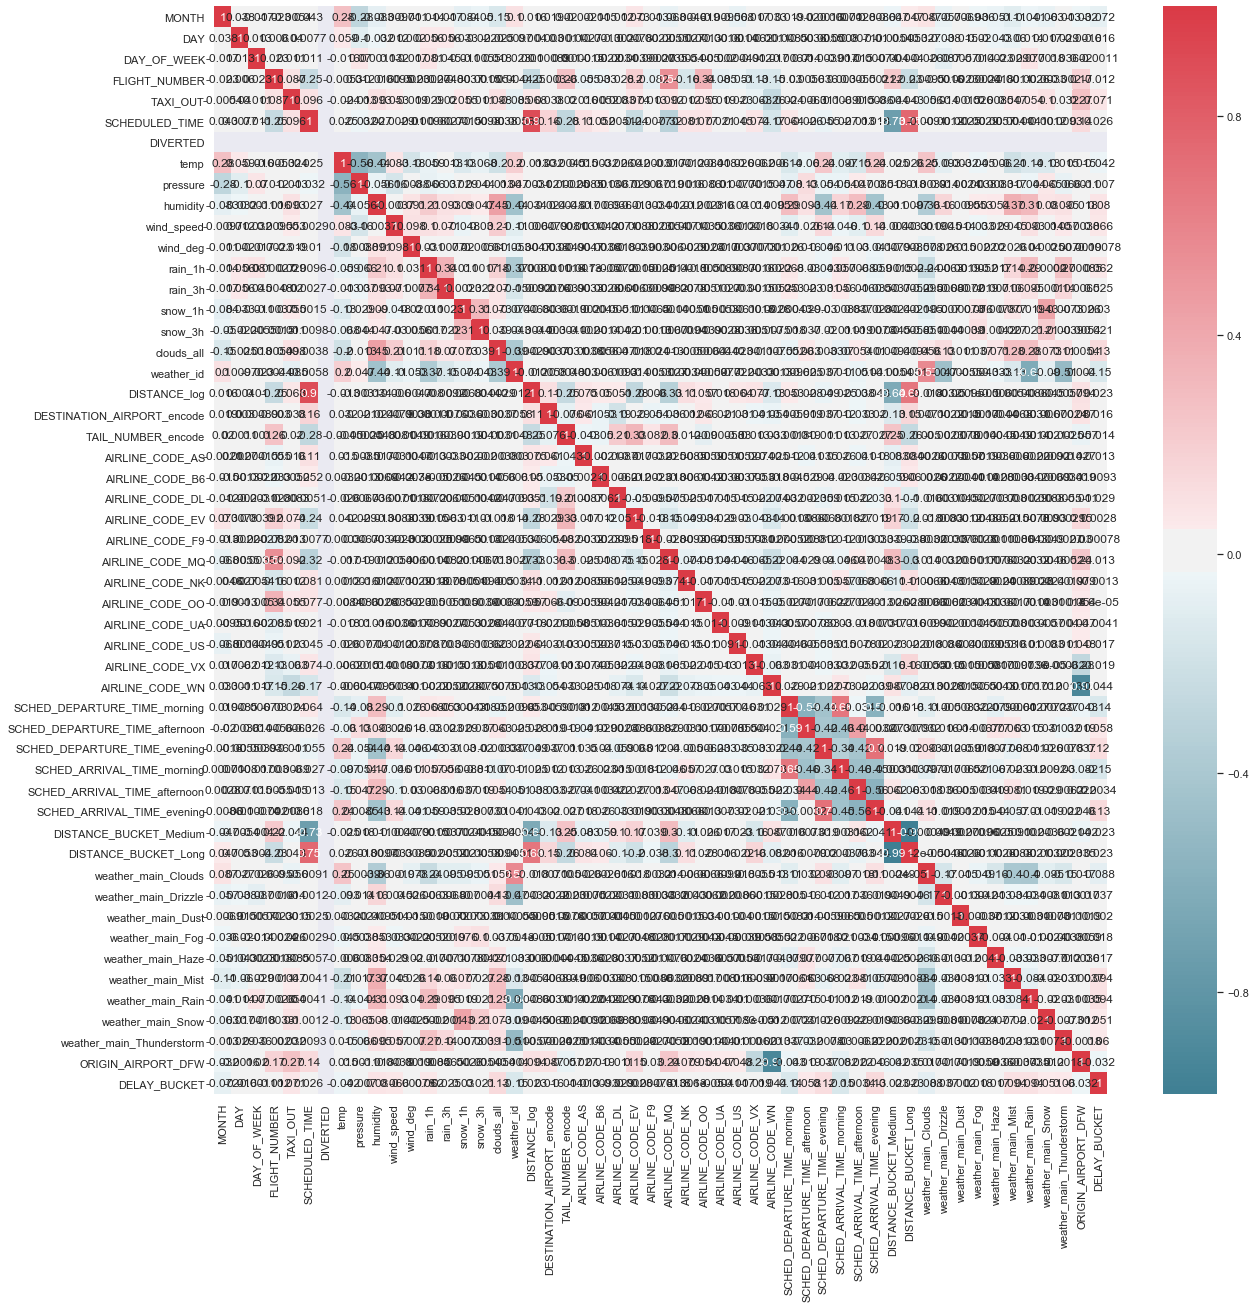

In [71]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Create heatmap
sns.heatmap(df_delay.corr(), cmap=cmap, annot = True)

We have too many features for this to be useful. Let's print out the variables that have a correlation greater than 0.8.

In [72]:
# Create correlation matrix with absolute values only
corr_matrix_abs = df_delay.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

['DISTANCE_log', 'DISTANCE_BUCKET_Long', 'ORIGIN_AIRPORT_DFW']


In [73]:
col_to_drop7 = ['DISTANCE_log', 'DIVERTED']

df_delay = df_delay.drop(columns = col_to_drop7)

#### 1.8.2 Cancel Data Set

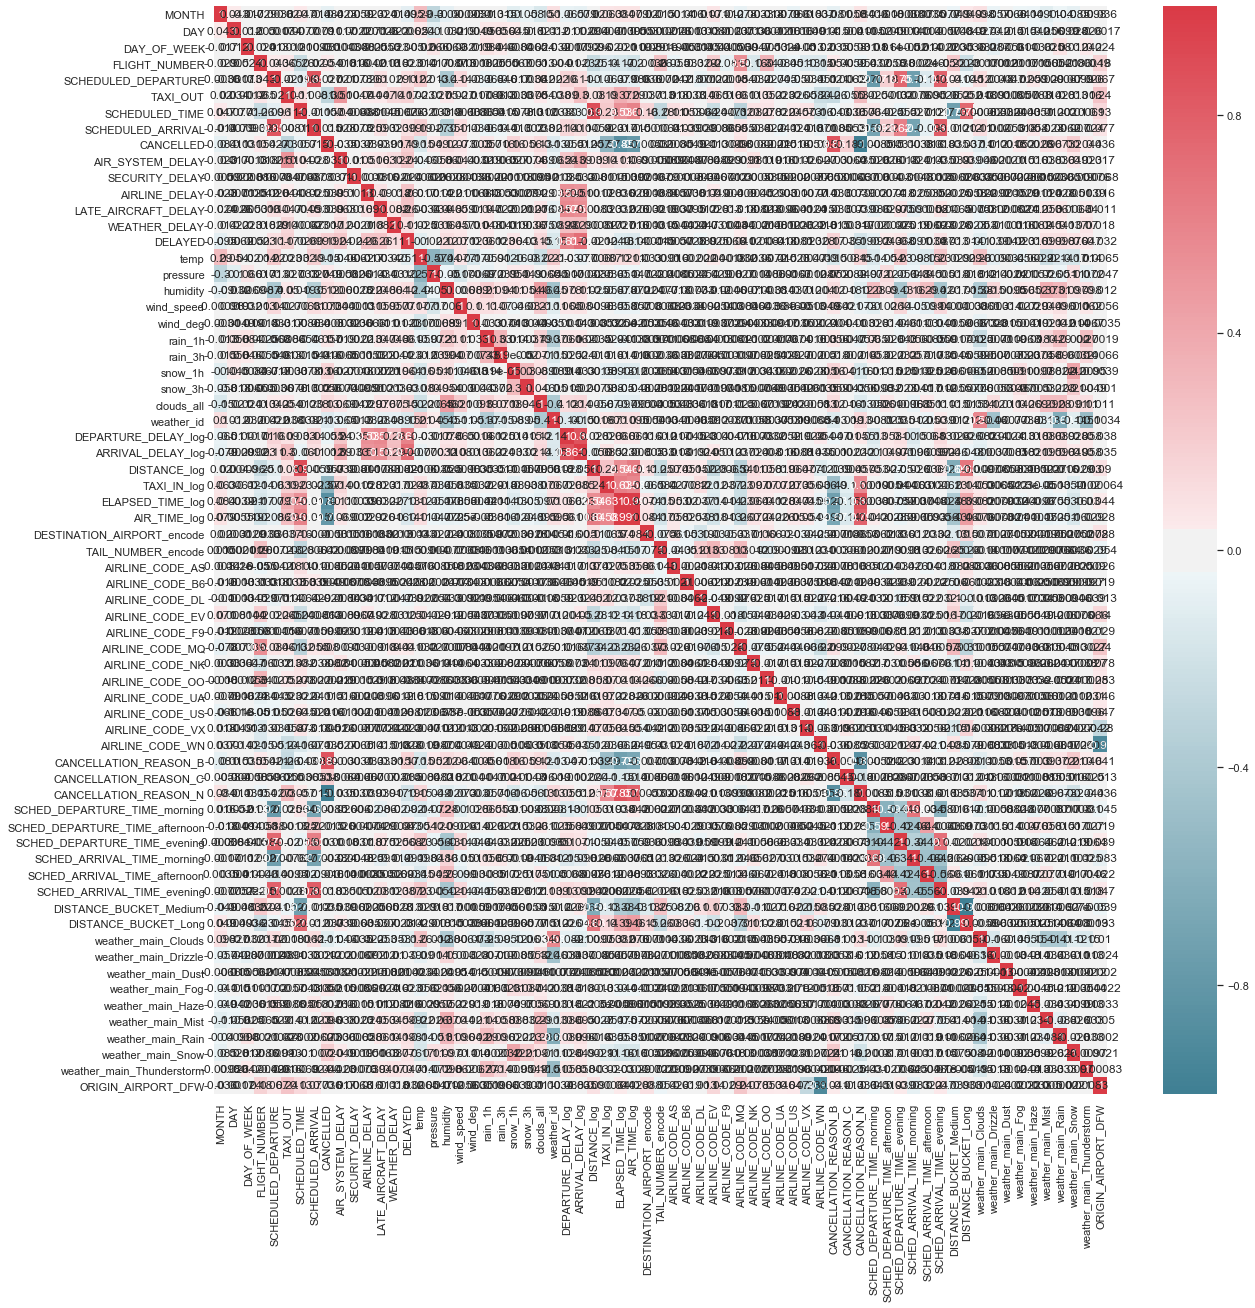

In [74]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Create heatmap
sns.heatmap(df_cancel.corr(), cmap=cmap, annot = True)

In [75]:
# Create correlation matrix with absolute values only
corr_matrix_abs = df_cancel.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

['SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY_log', 'DISTANCE_log', 'ELAPSED_TIME_log', 'AIR_TIME_log', 'CANCELLATION_REASON_B', 'CANCELLATION_REASON_N', 'SCHED_ARRIVAL_TIME_evening', 'DISTANCE_BUCKET_Long', 'ORIGIN_AIRPORT_DFW']


In [76]:
col_to_drop8 = ['ARRIVAL_DELAY_log', 'DISTANCE_log', 'ELAPSED_TIME_log', 'AIR_TIME_log']

df_cancel = df_cancel.drop(columns = col_to_drop8)

In [77]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 63 columns):
MONTH                             201236 non-null int64
DAY                               201236 non-null int64
DAY_OF_WEEK                       201236 non-null int64
FLIGHT_NUMBER                     201236 non-null int64
SCHEDULED_DEPARTURE               201236 non-null int32
TAXI_OUT                          201236 non-null float64
SCHEDULED_TIME                    201236 non-null int32
SCHEDULED_ARRIVAL                 201236 non-null int32
CANCELLED                         201236 non-null int64
AIR_SYSTEM_DELAY                  201236 non-null float64
SECURITY_DELAY                    201236 non-null float64
AIRLINE_DELAY                     201236 non-null float64
LATE_AIRCRAFT_DELAY               201236 non-null float64
WEATHER_DELAY                     201236 non-null float64
DELAYED                           201236 non-null int64
temp                              201

### 1.8 Final Data Sets

- **[5 points]** Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [78]:
#save data
#df_cancel.to_csv('../Data/df_cancel.csv', index=False)
#df_delay.to_csv('../Data/df_delay.csv', index=False)

In [2]:
#load data from here to save time
df_cancel = pd.read_csv('../Data/df_cancel.csv')
df_delay = pd.read_csv('../Data/df_delay.csv')

We will perform additional pre-processing (scaling, etc) within a pipeline in section 2 for our modelling.

## 2 Modeling & Evaluation

### 2.1 Evaluation Metrics

> **[10 points]** Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

### 2.2 Training & Testing Splits

> **[10 points]** Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

### 2.2.1 Cancel Data Set

In [80]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201236 entries, 0 to 201235
Data columns (total 63 columns):
MONTH                             201236 non-null int64
DAY                               201236 non-null int64
DAY_OF_WEEK                       201236 non-null int64
FLIGHT_NUMBER                     201236 non-null int64
SCHEDULED_DEPARTURE               201236 non-null int64
TAXI_OUT                          201236 non-null float64
SCHEDULED_TIME                    201236 non-null int64
SCHEDULED_ARRIVAL                 201236 non-null int64
CANCELLED                         201236 non-null int64
AIR_SYSTEM_DELAY                  201236 non-null float64
SECURITY_DELAY                    201236 non-null float64
AIRLINE_DELAY                     201236 non-null float64
LATE_AIRCRAFT_DELAY               201236 non-null float64
WEATHER_DELAY                     201236 non-null float64
DELAYED                           201236 non-null int64
temp                              201

In [81]:
#move response to end
cols = list(df_cancel.columns.values) 
cols.pop(cols.index('CANCELLED')) 
df_cancel = df_cancel[cols+['CANCELLED']]
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201236 entries, 0 to 201235
Data columns (total 63 columns):
MONTH                             201236 non-null int64
DAY                               201236 non-null int64
DAY_OF_WEEK                       201236 non-null int64
FLIGHT_NUMBER                     201236 non-null int64
SCHEDULED_DEPARTURE               201236 non-null int64
TAXI_OUT                          201236 non-null float64
SCHEDULED_TIME                    201236 non-null int64
SCHEDULED_ARRIVAL                 201236 non-null int64
AIR_SYSTEM_DELAY                  201236 non-null float64
SECURITY_DELAY                    201236 non-null float64
AIRLINE_DELAY                     201236 non-null float64
LATE_AIRCRAFT_DELAY               201236 non-null float64
WEATHER_DELAY                     201236 non-null float64
DELAYED                           201236 non-null int64
temp                              201236 non-null float64
pressure                          2

In [82]:
df_cancel['CANCELLED'].value_counts()

0    195553
1      5683
Name: CANCELLED, dtype: int64

In [83]:
#create X and y for cancellation data set
if 'CANCELLED' in df_cancel:
    y_can = df_cancel['CANCELLED'].values
    X_can = df_cancel.iloc[:,:-1].values
    
num_cv_iterations = 10
num_instances = len(y_can)

In [84]:
X_can.shape

(201236, 62)

In [85]:
y_can.shape

(201236,)

In [88]:
#scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_can)

X_can = scaler.transform(X_can)

#### 2.2.1.1 Undersampling

We know that our cancellation data set is highly imbalanced with around ~5600 cancellations versus ~200,000 total observations. First, we will undersample our majority class to get a 2:1 ratio of non-cancelled to cancelled flights.

In [89]:
#adapted from https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

#must install imbalanced-learn library https://github.com/scikit-learn-contrib/imbalanced-learn 

# Random undersampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

#check current class count
print(Counter(y_can))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
# fit and apply the transform
X_can_under, y_can_under = undersample.fit_resample(X_can, y_can)
# summarize class distribution
print(Counter(y_can_under))

Counter({0: 195553, 1: 5683})
Counter({0: 11366, 1: 5683})


This undersampling has now decreased our total count of 'non-cancels' from 195,553 to 11,366.

#### 2.2.1.2 SMOTE + Undersampling

In [90]:
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline

#adapted from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

#check current class count
print(Counter(y_can))
# define pipeline
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_can_smote, y_can_smote = pipeline.fit_resample(X_can, y_can)
# summarize the new class distribution
counter = Counter(y_can_smote)
print(counter)

Counter({0: 195553, 1: 5683})
Counter({0: 78220, 1: 39110})


#### 2.2.1.3 Stratified Shuffle Split

Below we will perform stratified shuffle split to create three train/test splits for modelling:
1. Split on the original data
2. Split on undersampled data
3. Split on SMOTE and undersampled data

In [91]:
from sklearn.model_selection import StratifiedShuffleSplit

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_can, y_can):
    X_train_can, X_test_can = X_can[train_index], X_can[test_index]
    y_train_can, y_test_can = y_can[train_index], y_can[test_index]

print(X_train_can.shape, X_test_can.shape, y_train_can.shape, y_test_can.shape)

(160988, 62) (40248, 62) (160988,) (40248,)


In [92]:
for train_index, test_index in sss.split(X_can_under, y_can_under):
    X_train_can_under, X_test_can_under = X_can_under[train_index], X_can_under[test_index]
    y_train_can_under, y_test_can_under = y_can_under[train_index], y_can_under[test_index]

print(X_train_can_under.shape, X_test_can_under.shape, y_train_can_under.shape, y_test_can_under.shape)

(13639, 62) (3410, 62) (13639,) (3410,)


In [93]:
for train_index, test_index in sss.split(X_can_smote, y_can_smote):
    X_train_can_smote, X_test_can_smote = X_can_smote[train_index], X_can_smote[test_index]
    y_train_can_smote, y_test_can_smote = y_can_smote[train_index], y_can_smote[test_index]

print(X_train_can_smote.shape, X_test_can_smote.shape, y_train_can_smote.shape, y_test_can_smote.shape)

(93864, 62) (23466, 62) (93864,) (23466,)


### 2.3 Create Models

> **[20 points]** Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.

### 2.3.1 Cancellations

#### Random Forest

We will test random forest on all three of our data sets - the original, undersampled, and the one with SMOTE + undersampling. First, we set a grid search and run it on the original data.

In [94]:
%%time
#run random forest on cancellations with grid search

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_can_rf = RandomForestClassifier(class_weight = 'balanced')

can_rf_params = {'n_estimators':[10, 20, 50, 100],
                   'max_depth': ['None', 10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10, 100],
                   'min_samples_leaf': [1, 2, 5, 10, 20],
                   'random_state': [13]
                  }

can_rf_grid = GridSearchCV(estimator = clf_can_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

can_rf_grid.fit(X_train_can,y_train_can)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


C:\Users\megan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  

Wall time: 2h 15min 13s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': ['None', 10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 100],
                         'n_estimators': [10, 20, 50, 100],
                         'random_state': [13]},
             scoring='accuracy', verbose=1)

In [95]:
#print best estimator
print(can_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=10,
                       random_state=13)
Accuracy: 1.0


We are overfitting our data since we got 100% accuracy on multiple models. Let's check variable importance to see which variables we may need to remove.

In [96]:
#run best estimator params
from sklearn import metrics 

rf_v0 = rf_v0 = RandomForestClassifier(class_weight = 'balanced', max_depth=10, n_estimators=5, random_state=13)

rf_v0.fit(X_train_can,y_train_can)
y_pred_v0 = rf_v0.predict(X_test_can)

print("Accuracy:",metrics.accuracy_score(y_test_can, y_pred_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_can,y_pred_v0))
print("Precision:",metrics.precision_score(y_test_can,y_pred_v0))
print("Recall:",metrics.recall_score(y_test_can,y_pred_v0))

features_can = df_cancel.iloc[:,:-1]

feature_imp = pd.Series(rf_v0.feature_importances_,index=features_can.columns).sort_values(ascending=False)
feature_imp

Accuracy: 1.0
Kappa: 1.0
Precision: 1.0
Recall: 1.0


DEPARTURE_DELAY_log               3.598235e-01
TAXI_OUT                          2.935171e-01
TAXI_IN_log                       8.598401e-02
CANCELLATION_REASON_N             8.561243e-02
DELAYED                           8.348674e-02
weather_main_Clouds               2.974833e-02
AIRLINE_DELAY                     2.267462e-02
weather_id                        1.833994e-02
wind_speed                        1.053948e-02
clouds_all                        5.967670e-03
pressure                          1.592402e-03
AIR_SYSTEM_DELAY                  1.380694e-03
CANCELLATION_REASON_B             5.239891e-04
MONTH                             3.431022e-04
DAY_OF_WEEK                       3.049693e-04
FLIGHT_NUMBER                     9.440560e-05
AIRLINE_CODE_US                   2.725704e-05
AIRLINE_CODE_UA                   2.202887e-05
AIRLINE_CODE_F9                   1.733896e-05
weather_main_Dust                 6.177415e-13
SCHED_DEPARTURE_TIME_evening      3.223883e-14
SCHED_DEPARTU

We may need to remove `CANCELLATION_REASON` categories as `CANCELLATION_REASON_N` has a perfect correlation to the flight not being cancelled. Let's try KNN first before modifying our data set again.

#### KNN

In [97]:
%%time
from sklearn.neighbors import KNeighborsClassifier

#set k_range to try k values from 1 to 15
k_range = range(1,16)

#make a list of each accuracy (defined later) for each k
scores_v0 = {}
scores_v0_list = []

#make a list of kappa for each k
kappa_v0 = {}
kappa_v0_list = []

#fit data
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_can,y_train_can)
    
    y_pred = knn.predict(X_test_can)
    
    scores_v0[k] = metrics.accuracy_score(y_test_can,y_pred)
    scores_v0_list.append(scores_v0[k])
    
    kappa_v0[k] = metrics.cohen_kappa_score(y_test_can,y_pred)
    kappa_v0_list.append(kappa_v0[k])

print(scores_v0)
print(kappa_v0)

{1: 0.999950308089843, 2: 0.9998757702246074, 3: 0.999900616179686, 4: 0.9998260783144504, 5: 0.9998260783144504, 6: 0.9997763864042933, 7: 0.9998012323593719, 8: 0.9997515404492149, 9: 0.9997763864042933, 10: 0.9997018485390579, 11: 0.9997018485390579, 12: 0.9996521566289008, 13: 0.9996521566289008, 14: 0.9995776187636652, 15: 0.9995776187636652}
{1: 0.9990941507295105, 2: 0.9977324698419842, 3: 0.9981867517318339, 4: 0.9968227387861747, 5: 0.9968227387861747, 6: 0.9959114480267922, 7: 0.9963672886200158, 8: 0.995455216504258, 9: 0.9959114480267922, 10: 0.9945415786579631, 11: 0.9945415786579631, 12: 0.9936263710458942, 13: 0.9936263710458942, 14: 0.9922506074557154, 15: 0.9922506074557154}
Wall time: 28min 10s


In [98]:
#find key (k-value) for best accuracy
max_key = max(scores_v0, key=lambda k: scores_v0[k])

print("Best K-value for accuracy:",max_key)
print("Best Accuracy:",max(scores_v0_list))
print("Best Kappa:",kappa_v0[max_key])

Best K-value for accuracy: 1
Best Accuracy: 0.999950308089843
Best Kappa: 0.9990941507295105


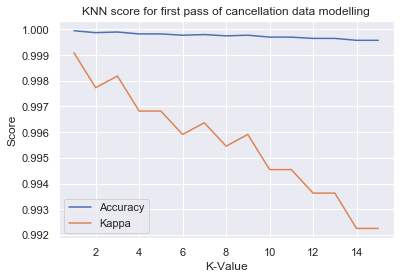

In [99]:
plt.plot(k_range,scores_v0_list)
plt.plot(k_range,kappa_v0_list)
plt.xlabel("K-Value")
plt.ylabel("Score")
plt.legend(["Accuracy","Kappa"])
plt.title("KNN score for first pass of cancellation data modelling")
plt.show()

We see the same overfit here. Let's remove `CANCELLATION_REASON` from our splits and run again.

In [100]:
df_cancel.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DELAYED', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'DEPARTURE_DELAY_log', 'TAXI_IN_log',
       'DESTINATION_AIRPORT_encode', 'TAIL_NUMBER_encode', 'AIRLINE_CODE_AS',
       'AIRLINE_CODE_B6', 'AIRLINE_CODE_DL', 'AIRLINE_CODE_EV',
       'AIRLINE_CODE_F9', 'AIRLINE_CODE_MQ', 'AIRLINE_CODE_NK',
       'AIRLINE_CODE_OO', 'AIRLINE_CODE_UA', 'AIRLINE_CODE_US',
       'AIRLINE_CODE_VX', 'AIRLINE_CODE_WN', 'CANCELLATION_REASON_B',
       'CANCELLATION_REASON_C', 'CANCELLATION_REASON_N',
       'SCHED_DEPARTURE_TIME_morning', 'SCHED_DEPARTURE_TIME_afternoon',
       'SCHED_DEPARTURE_TIME_evening', 'SCHED_ARRIVAL_TIME_morning',
       'SCHED_ARRIVAL_T

In [101]:
#separate data to features and target variable and drop cancel columns
cols = ['CANCELLATION_REASON_B', 'CANCELLATION_REASON_C', 'CANCELLATION_REASON_N']
df_cancel = df_cancel.drop(columns = cols)

#create X and y for cancellation data set
if 'CANCELLED' in df_cancel:
    y_can = df_cancel['CANCELLED'].values
    X_can = df_cancel.iloc[:,:-1].values
    
num_cv_iterations = 10
num_instances = len(y_can)

X_can.shape, y_can.shape

((201236, 59), (201236,))

In [102]:
# Random undersampling

#check current class count
print(Counter(y_can))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
# fit and apply the transform
X_can_under, y_can_under = undersample.fit_resample(X_can, y_can)
# summarize class distribution
print(Counter(y_can_under))

Counter({0: 195553, 1: 5683})
Counter({0: 11366, 1: 5683})


In [104]:
#adapted from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

#check current class count
print(Counter(y_can))
# define pipeline
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_can_smote, y_can_smote = pipeline.fit_resample(X_can, y_can)
# summarize the new class distribution
counter = Counter(y_can_smote)
print(counter)

Counter({0: 195553, 1: 5683})
Counter({0: 78220, 1: 39110})


In [105]:
sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_can, y_can):
    X_train_can, X_test_can = X_can[train_index], X_can[test_index]
    y_train_can, y_test_can = y_can[train_index], y_can[test_index]

print(X_train_can.shape, X_test_can.shape, y_train_can.shape, y_test_can.shape)

for train_index, test_index in sss.split(X_can_under, y_can_under):
    X_train_can_under, X_test_can_under = X_can_under[train_index], X_can_under[test_index]
    y_train_can_under, y_test_can_under = y_can_under[train_index], y_can_under[test_index]

print(X_train_can_under.shape, X_test_can_under.shape, y_train_can_under.shape, y_test_can_under.shape)

for train_index, test_index in sss.split(X_can_smote, y_can_smote):
    X_train_can_smote, X_test_can_smote = X_can_smote[train_index], X_can_smote[test_index]
    y_train_can_smote, y_test_can_smote = y_can_smote[train_index], y_can_smote[test_index]

print(X_train_can_smote.shape, X_test_can_smote.shape, y_train_can_smote.shape, y_test_can_smote.shape)

(160988, 59) (40248, 59) (160988,) (40248,)
(13639, 59) (3410, 59) (13639,) (3410,)
(93864, 59) (23466, 59) (93864,) (23466,)


#### Re-Run Random Forest without Cancellation Reason

In [106]:
%%time
#run random forest on cancellations

#test using standard classifier with defaults
clf_can_rf = RandomForestClassifier(class_weight = 'balanced')

clf_can_rf.fit(X_train_can,y_train_can)
y_pred_can = clf_can_rf.predict(X_test_can)

print(metrics.accuracy_score(y_test_can,y_pred_can))

1.0
Wall time: 11.9 s


In [107]:
features_can = df_cancel.iloc[:,:-1]

feature_imp = pd.Series(clf_can_rf.feature_importances_,index=features_can.columns).sort_values(ascending=False)
feature_imp

TAXI_IN_log                       3.471010e-01
TAXI_OUT                          2.520611e-01
DEPARTURE_DELAY_log               1.303334e-01
DELAYED                           9.185046e-02
clouds_all                        2.838492e-02
temp                              2.454796e-02
weather_id                        1.978651e-02
AIRLINE_DELAY                     1.578628e-02
humidity                          1.337805e-02
rain_1h                           1.053813e-02
MONTH                             8.641442e-03
AIR_SYSTEM_DELAY                  8.203033e-03
LATE_AIRCRAFT_DELAY               7.987660e-03
weather_main_Clouds               6.853610e-03
snow_1h                           6.353975e-03
pressure                          5.582520e-03
wind_speed                        5.119636e-03
WEATHER_DELAY                     2.066937e-03
weather_main_Mist                 1.827012e-03
SCHEDULED_DEPARTURE               1.599799e-03
FLIGHT_NUMBER                     1.583169e-03
wind_deg     

In [108]:
#try running with our balanced data sets - unbalanced and SMOTE - if still high, eliminate more features

clf_can_rf_smote = RandomForestClassifier(class_weight = 'balanced')

clf_can_rf_smote.fit(X_train_can_smote,y_train_can_smote)
y_pred_can_smote = clf_can_rf_smote.predict(X_test_can_smote)

print(metrics.accuracy_score(y_test_can_smote,y_pred_can_smote))

1.0


Eliminate all other features that reasonably correlate to cancels - meaning anything that is either a 0 or 1 and correlates closely to cancel (i.e. `DELAYED` being 1 means `CANCELLED` will be 0.)

In [3]:
df_cancel.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'CANCELLED',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DELAYED', 'temp', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds_all', 'weather_id', 'DEPARTURE_DELAY_log',
       'TAXI_IN_log', 'DESTINATION_AIRPORT_encode', 'TAIL_NUMBER_encode',
       'AIRLINE_CODE_AS', 'AIRLINE_CODE_B6', 'AIRLINE_CODE_DL',
       'AIRLINE_CODE_EV', 'AIRLINE_CODE_F9', 'AIRLINE_CODE_MQ',
       'AIRLINE_CODE_NK', 'AIRLINE_CODE_OO', 'AIRLINE_CODE_UA',
       'AIRLINE_CODE_US', 'AIRLINE_CODE_VX', 'AIRLINE_CODE_WN',
       'CANCELLATION_REASON_B', 'CANCELLATION_REASON_C',
       'CANCELLATION_REASON_N', 'SCHED_DEPARTURE_TIME_morning',
       'SCHED_DEPARTURE_TIME_afternoon', 'SCHED_DEPARTURE_TIME_evening',
       'SCHED_ARRIVAL_TIME_morning', 'SC

In [4]:
cols = ['TAXI_OUT', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 
       'DELAYED', 'DEPARTURE_DELAY_log', 'TAXI_IN_log']

df_cancel = df_cancel.drop(columns = cols)

In [7]:
#create X and y for cancellation data set
if 'CANCELLED' in df_cancel:
    y_can = df_cancel['CANCELLED'].values
    X_can = df_cancel.iloc[:,:-1].values
    
num_cv_iterations = 10
num_instances = len(y_can)

X_can.shape, y_can.shape

#check current class count
print(Counter(y_can))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
# fit and apply the transform
X_can_under, y_can_under = undersample.fit_resample(X_can, y_can)
# summarize class distribution
print(Counter(y_can_under))

# define pipeline
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_can_smote, y_can_smote = pipeline.fit_resample(X_can, y_can)
# summarize the new class distribution
counter = Counter(y_can_smote)
print(counter)

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_can, y_can):
    X_train_can, X_test_can = X_can[train_index], X_can[test_index]
    y_train_can, y_test_can = y_can[train_index], y_can[test_index]

print(X_train_can.shape, X_test_can.shape, y_train_can.shape, y_test_can.shape)

for train_index, test_index in sss.split(X_can_under, y_can_under):
    X_train_can_under, X_test_can_under = X_can_under[train_index], X_can_under[test_index]
    y_train_can_under, y_test_can_under = y_can_under[train_index], y_can_under[test_index]

print(X_train_can_under.shape, X_test_can_under.shape, y_train_can_under.shape, y_test_can_under.shape)

for train_index, test_index in sss.split(X_can_smote, y_can_smote):
    X_train_can_smote, X_test_can_smote = X_can_smote[train_index], X_can_smote[test_index]
    y_train_can_smote, y_test_can_smote = y_can_smote[train_index], y_can_smote[test_index]

print(X_train_can_smote.shape, X_test_can_smote.shape, y_train_can_smote.shape, y_test_can_smote.shape)

Counter({0: 195553, 1: 5683})
Counter({0: 11366, 1: 5683})
Counter({0: 78220, 1: 39110})
(160988, 53) (40248, 53) (160988,) (40248,)
(13639, 53) (3410, 53) (13639,) (3410,)
(93864, 53) (23466, 53) (93864,) (23466,)


#### Running Random Forest Again!

In [113]:
%%time
#run random forest on cancellations

#test using standard classifier with defaults
clf_can_rf = RandomForestClassifier(class_weight = 'balanced')

clf_can_rf.fit(X_train_can,y_train_can)
y_pred_can = clf_can_rf.predict(X_test_can)

print(metrics.accuracy_score(y_test_can,y_pred_can))

0.9825581395348837
Wall time: 37.5 s


In [114]:
clf_can_rf_smote = RandomForestClassifier()

clf_can_rf_smote.fit(X_train_can_smote,y_train_can_smote)
y_pred_can_smote = clf_can_rf_smote.predict(X_test_can_smote)

print(metrics.accuracy_score(y_test_can_smote,y_pred_can_smote))

0.9676553311173612


In [115]:
clf_can_rf_under = RandomForestClassifier()

clf_can_rf_under.fit(X_train_can_under,y_train_can_under)
y_pred_can_under = clf_can_rf_under.predict(X_test_can_under)

print(metrics.accuracy_score(y_test_can_under,y_pred_can_under))

0.8932551319648094


This is better - there is likely still some overfit on the original data and SMOTE sampled data, but with the undersampling we have a more reasonable accuracy at 89%. Let's run grid search on our SMOTE and undersampled data sets to see which of these two will be best to use for the rest of the model building - as it's pretty clear at this point the unbalanced data set is giving us some overfit.

In [119]:
%%time
#run random forest on cancellations with grid search - original data

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_can_rf = RandomForestClassifier(class_weight = 'balanced')

can_rf_params = {'n_estimators':[20, 50, 100],
                   'max_depth': [10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 5, 10],
                   'random_state': [13]
                  }

can_rf_grid = GridSearchCV(estimator = clf_can_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

can_rf_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Wall time: 13min 36s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100], 'random_state': [13]},
             scoring='accuracy', verbose=1)

In [120]:
#print best estimator
print(can_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)
Accuracy: 0.8899470828322034


In [121]:
rf_v1 = RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)

rf_v1.fit(X_train_can_under,y_train_can_under)
y_pred_v1 = rf_v1.predict(X_test_can_under)

print("Accuracy:",metrics.accuracy_score(y_test_can_under, y_pred_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_under,y_pred_v1))
print("Precision:",metrics.precision_score(y_test_can_under,y_pred_v1))
print("Recall:",metrics.recall_score(y_test_can_under,y_pred_v1))

Accuracy: 0.8926686217008798
Kappa: 0.752111026675782
Precision: 0.8783120706575074
Recall: 0.7871591908531222


In [122]:
%%time
#run random forest on cancellations with grid search - SMOTE data

can_rf_params = {'n_estimators':[20, 50, 100],
                   'max_depth': [10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 5, 10],
                   'random_state': [13]
                  }

can_rf_grid = GridSearchCV(estimator = clf_can_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

can_rf_grid.fit(X_train_can_smote,y_train_can_smote)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
Wall time: 2h 33min 36s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100], 'random_state': [13]},
             scoring='accuracy', verbose=1)

In [123]:
#print best estimator
print(can_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)
Accuracy: 0.9682519876936952


In [124]:
rf_v2 = RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)

rf_v2.fit(X_train_can_smote,y_train_can_smote)
y_pred_v2 = rf_v2.predict(X_test_can_smote)

print("Accuracy:",metrics.accuracy_score(y_test_can_smote, y_pred_v2))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_smote,y_pred_v2))
print("Precision:",metrics.precision_score(y_test_can_smote,y_pred_v2))
print("Recall:",metrics.recall_score(y_test_can_smote,y_pred_v2))

Accuracy: 0.9679110201994375
Kappa: 0.9270372403992119
Precision: 0.971581054036024
Recall: 0.9309639478394273


#### KNN 

In [10]:
#Create KNN Classifier
can_knn_params = {
    "n_neighbors": [1,3,5,7],
    "weights": ["uniform", "distance"],
}

can_knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_knn_params,
                               cv = 10,
                               scoring = 'accuracy')

can_knn_grid.fit(X_train_can_smote,y_train_can_smote)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [11]:
#print best estimator
print(can_knn_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_knn_grid.best_score_))

KNeighborsClassifier(n_neighbors=1)
Accuracy: 0.9239644649124283


In [12]:
knn_v0 = KNeighborsClassifier(n_neighbors=1)

knn_v0.fit(X_train_can_smote,y_train_can_smote)
y_pred_knn_v0 = knn_v0.predict(X_test_can_smote)

print("Accuracy:",metrics.accuracy_score(y_test_can_smote, y_pred_knn_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_smote,y_pred_knn_v0))
print("Precision:",metrics.precision_score(y_test_can_smote,y_pred_knn_v0))
print("Recall:",metrics.recall_score(y_test_can_smote,y_pred_knn_v0))

Accuracy: 0.930580414216313
Kappa: 0.847037465961376
Precision: 0.8650241659790169
Recall: 0.9381232421375607


In [13]:
#Create KNN Classifier - run on under sampled data

can_knn_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [14]:
#print best estimator
print(can_knn_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_knn_grid.best_score_))

KNeighborsClassifier(n_neighbors=7, weights='distance')
Accuracy: 0.7179412220326474


In [15]:
knn_v1 = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn_v1.fit(X_train_can_under,y_train_can_under)
y_pred_knn_v1 = knn_v1.predict(X_test_can_under)

print("Accuracy:",metrics.accuracy_score(y_test_can_under, y_pred_knn_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_under,y_pred_knn_v1))
print("Precision:",metrics.precision_score(y_test_can_under,y_pred_knn_v1))
print("Recall:",metrics.recall_score(y_test_can_under,y_pred_knn_v1))

Accuracy: 0.7178885630498534
Kappa: 0.3525353089530928
Precision: 0.5835721107927412
Recall: 0.5373790677220757


In [20]:
%%time
#update the grid to run higher K to see if accuracy increases

can_knn_params = {
    "n_neighbors": [7,9,11,13],
    "weights": ["uniform", "distance"],
}

can_knn_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Wall time: 9.79 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [21]:
#print best estimator
print(can_knn_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_knn_grid.best_score_))

KNeighborsClassifier(n_neighbors=7, weights='distance')
Accuracy: 0.7179412220326474


Even with higher K-values, the best accuracy is achieved at k=7.

#### SVM

In [17]:
%%time

from sklearn.linear_model import SGDClassifier

#Create SVM Classifier
can_svm_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01],
    "random_state": [42]
}

can_svm_grid = GridSearchCV(estimator = SGDClassifier(early_stopping=True, class_weight = 'balanced'),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_svm_params,
                               cv = 10,
                               scoring = 'accuracy')

can_svm_grid.fit(X_train_can_smote,y_train_can_smote)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Wall time: 13 s


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='accuracy', verbose=1)

In [18]:
#print best estimator
print(can_svm_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_svm_grid.best_score_))

SGDClassifier(class_weight='balanced', early_stopping=True,
              penalty='elasticnet', random_state=42)
Accuracy: 0.6338341971640602


In [19]:
svm_v1 = SGDClassifier(class_weight='balanced', early_stopping=True,
              penalty='elasticnet', random_state=42)

svm_v1.fit(X_train_can_smote,y_train_can_smote)
y_pred_svm_v1 = svm_v1.predict(X_test_can_smote)

print("Accuracy:",metrics.accuracy_score(y_test_can_smote, y_pred_svm_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_smote,y_pred_svm_v1))
print("Precision:",metrics.precision_score(y_test_can_smote,y_pred_svm_v1))
print("Recall:",metrics.recall_score(y_test_can_smote,y_pred_svm_v1))

Accuracy: 0.3333333333333333
Kappa: 0.0
Precision: 0.3333333333333333
Recall: 1.0


In [22]:
#run grid search on undersampled data
can_svm_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='accuracy', verbose=1)

In [23]:
#print best estimator
print(can_svm_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_svm_grid.best_score_))

SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              penalty='l1', random_state=42)
Accuracy: 0.5716681763317505


In [24]:
svm_v2 = SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              penalty='l1', random_state=42)

svm_v2.fit(X_train_can_under,y_train_can_under)
y_pred_svm_v2 = svm_v2.predict(X_test_can_under)

print("Accuracy:",metrics.accuracy_score(y_test_can_under, y_pred_svm_v2))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_under,y_pred_svm_v2))
print("Precision:",metrics.precision_score(y_test_can_under,y_pred_svm_v2))
print("Recall:",metrics.recall_score(y_test_can_under,y_pred_svm_v2))

Accuracy: 0.6621700879765395
Kappa: 0.16392004423541306
Precision: 0.4896265560165975
Recall: 0.3113456464379947


### 2.4 Analyze Model Results

> **[10 points]** Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

### 2.5 Discuss Model Advantages

> **[10 points]** Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

## 3 Important Attributes

> **[10 points]** Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## 4 Deployment

> **[5 points]** How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

## 5 Exceptional Work

> - You have free reign to provide additional modeling.
> - One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?